<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclustering/applications/clustering/20newsgroup/Topic%20Identification%20in%20News%20using%20LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [1]:
!pip install pyldavis -q

     |████████████████████████████████| 1.6MB 2.6MB/s 
     |████████████████████████████████| 552kB 13.5MB/s 


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Imports

In [3]:
import re
import spacy
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
np.random.seed(42)

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

nlp = spacy.load('en', disable=['parser', 'ner'])

### 20 Newsgroup Dataset

In [ ]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [70]:
df.target_names.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

In [ ]:
len(df)

11314

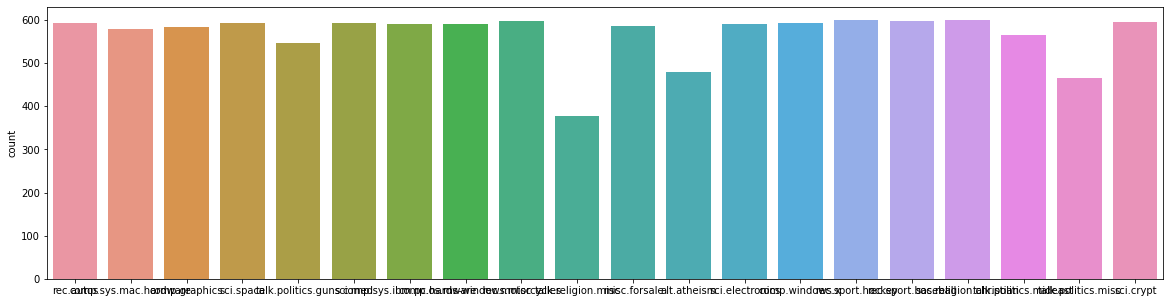

In [ ]:
plt.figure(figsize=(20, 5))
sns.countplot(df.target_names.values)

In [ ]:
data = df.content.values

### Tokenization

In [ ]:
def sentence_to_tokens(sent):
    # remove emails
    sent = re.sub(r'\S*@\S*\s?', '', sent)
    # remove newline chars
    sent = re.sub(r'\s+', ' ', sent)
    # remove single quotes
    sent = re.sub(r"\'", "", sent)
    # converts to lower case tokens and removes tokens that are
    # too small & too long. Also remove accent characters & punct
    tokens = simple_preprocess(str(sent), deacc=True)
    return tokens

In [ ]:
%%time
tokenized_data = [sentence_to_tokens(doc) for doc in data]

CPU times: user 9.41 s, sys: 171 ms, total: 9.58 s
Wall time: 9.59 s


In [ ]:
tokenized_data[0]

['from',
 'wheres',
 'my',
 'thing',
 'subject',
 'what',
 'car',
 'is',
 'this',
 'nntp',
 'posting',
 'host',
 'rac',
 'wam',
 'umd',
 'edu',
 'organization',
 'university',
 'of',
 'maryland',
 'college',
 'park',
 'lines',
 'was',
 'wondering',
 'if',
 'anyone',
 'out',
 'there',
 'could',
 'enlighten',
 'me',
 'on',
 'this',
 'car',
 'saw',
 'the',
 'other',
 'day',
 'it',
 'was',
 'door',
 'sports',
 'car',
 'looked',
 'to',
 'be',
 'from',
 'the',
 'late',
 'early',
 'it',
 'was',
 'called',
 'bricklin',
 'the',
 'doors',
 'were',
 'really',
 'small',
 'in',
 'addition',
 'the',
 'front',
 'bumper',
 'was',
 'separate',
 'from',
 'the',
 'rest',
 'of',
 'the',
 'body',
 'this',
 'is',
 'all',
 'know',
 'if',
 'anyone',
 'can',
 'tellme',
 'model',
 'name',
 'engine',
 'specs',
 'years',
 'of',
 'production',
 'where',
 'this',
 'car',
 'is',
 'made',
 'history',
 'or',
 'whatever',
 'info',
 'you',
 'have',
 'on',
 'this',
 'funky',
 'looking',
 'car',
 'please',
 'mail',
 'than

### Pre-processing

In [ ]:
%%time
# create bigrams from the tokenized data
bigram = gensim.models.Phrases(tokenized_data, threshold=50)
# make a bigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)

CPU times: user 13.8 s, sys: 48.3 ms, total: 13.8 s
Wall time: 13.8 s


In [ ]:
def process_words(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # remove stopwords
    stop_free = [[word for word in doc if word not in stop_words] for doc in texts]
    # bigrams
    bigram_data = [bigram_mod[doc] for doc in stop_free]

    texts_out = []
    for sent in bigram_data:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [ ]:
%%time
processed_data = process_words(tokenized_data)

CPU times: user 1min 40s, sys: 615 ms, total: 1min 41s
Wall time: 1min 41s


In [ ]:
processed_data[0]

['thing',
 'car',
 'nntp_posting',
 'host_rac',
 'park',
 'line',
 'wonder',
 'could',
 'enlighten',
 'car',
 'see',
 'day',
 'door',
 'look',
 'late',
 'early',
 'call',
 'bricklin',
 'door',
 'really',
 'small',
 'addition',
 'separate',
 'rest',
 'body',
 'know',
 'tellme',
 'model',
 'name',
 'engine',
 'year',
 'production',
 'car',
 'make',
 'history',
 'info',
 'funky',
 'look',
 'car',
 'mail',
 'thank',
 'bring',
 'neighborhood',
 'lerxst']

### Vocabulary & Corpus

In [ ]:
# create dictionary
id2word = corpora.Dictionary(processed_data)

# create corpus -> Bag of words
corpus = [id2word.doc2bow(text) for text in processed_data]

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 4),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host_rac', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_posting', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('wonder', 1),
  ('year', 1)]]

### LDA Model

In [ ]:
%%time
# lda model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20,
    random_state=42,
    passes=30
)

CPU times: user 5min 22s, sys: 2min 38s, total: 8min
Wall time: 4min 53s


In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.037*"write" + 0.030*"line" + 0.028*"article" + 0.018*"would" + '
  '0.015*"know" + 0.014*"go" + 0.012*"think" + 0.012*"say" + 0.012*"get" + '
  '0.011*"host"'),
 (1,
  '0.026*"line" + 0.013*"would" + 0.013*"write" + 0.013*"window" + '
  '0.012*"problem" + 0.011*"know" + 0.011*"thank" + 0.011*"drive" + '
  '0.010*"get" + 0.010*"card"'),
 (2,
  '0.014*"copy" + 0.010*"issue" + 0.009*"section" + 0.009*"cover" + '
  '0.008*"appear" + 0.008*"cell" + 0.007*"division" + 0.007*"information" + '
  '0.007*"art" + 0.006*"explosive"'),
 (3,
  '0.032*"line" + 0.017*"mail" + 0.015*"ca" + 0.015*"would" + 0.013*"thank" + '
  '0.013*"address" + 0.012*"host" + 0.012*"organization" + 0.006*"nntp_poste" '
  '+ 0.006*"ride"'),
 (4,
  '0.019*"space" + 0.015*"mission" + 0.010*"battery" + 0.009*"flight" + '
  '0.009*"water" + 0.009*"spacecraft" + 0.008*"earth" + 0.007*"rocket" + '
  '0.007*"launch" + 0.007*"first"'),
 (5,
  '0.014*"people" + 0.008*"government" + 0.007*"state" + 0.006*"kill" + '
  '0.

### Evaluation

In [71]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.8952022883840804


In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4418347046272526


### Visualization of Topics

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.166622  0.025866       1        1  16.077114
1      0.128206 -0.084102       2        1   9.713155
5      0.075098  0.024277       3        1   9.147898
6      0.134551  0.014418       4        1   8.654360
7      0.000099 -0.241904       5        1   8.392344
0      0.148242  0.135458       6        1   6.813948
11     0.152099  0.051824       7        1   6.767522
14     0.097878  0.086753       8        1   5.021500
16     0.117401  0.026289       9        1   4.877497
19     0.113916  0.195040      10        1   4.528769
8      0.087976 -0.083542      11        1   4.323881
18    -0.006176 -0.148240      12        1   3.682077
15    -0.019677 -0.012232      13        1   2.236947
12    -0.046905 -0.126788      14        1   1.983126
13     0.009262  0.007228      15        1   1.869873
9     -0.118128 -0.071723      16        1   1.589101
4     -0.202631  0.022701      17        1   1.476663
10    -0.347746  0.191672      18        1   1.052424
3     -0.218448  0.007613      19        1   0.926290
2     -0.271640 -0.020608      20        1   0.865506, topic_info=       Term          Freq         Total Category  logprob  loglift
3659     ax   4093.000000   4093.000000  Default  30.0000  30.0000
1754    max   3316.000000   3316.000000  Default  29.0000  29.0000
19     line  11368.000000  11368.000000  Default  28.0000  28.0000
313    file   2301.000000   2301.000000  Default  27.0000  27.0000
188   write   9762.000000   9762.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
846     age     36.876892    395.912079  Topic20  -5.5380   2.3760
313    file     42.323715   2301.597656  Topic20  -5.4002   0.7536
19     line     46.942711  11368.072266  Topic20  -5.2966  -0.7400
459    sell     33.659821    901.743286  Topic20  -5.6292   1.4616
397    help     33.830704   2105.150146  Topic20  -5.6242   0.6188

[1430 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
15032     15  0.970465       aaa
7782       1  0.965429  absolute
7782      15  0.018448  absolute
7782      16  0.012298  absolute
1188       1  0.630706    accept
...      ...       ...       ...
38        13  0.044269      year
38        14  0.037431      year
38        15  0.025913      year
38        17  0.019795      year
3773      13  0.966988     yeast

[4219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 2, 6, 7, 8, 1, 12, 15, 17, 20, 9, 19, 16, 13, 14, 10, 5, 11, 4, 3])

### Word Cloud of Topics

In [83]:
cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    max_words=20,
    colormap='tab10',
    prefer_horizontal=1.0
)


In [89]:
topics = lda_model.show_topics(num_topics=20, formatted=False)
len(topics)

20

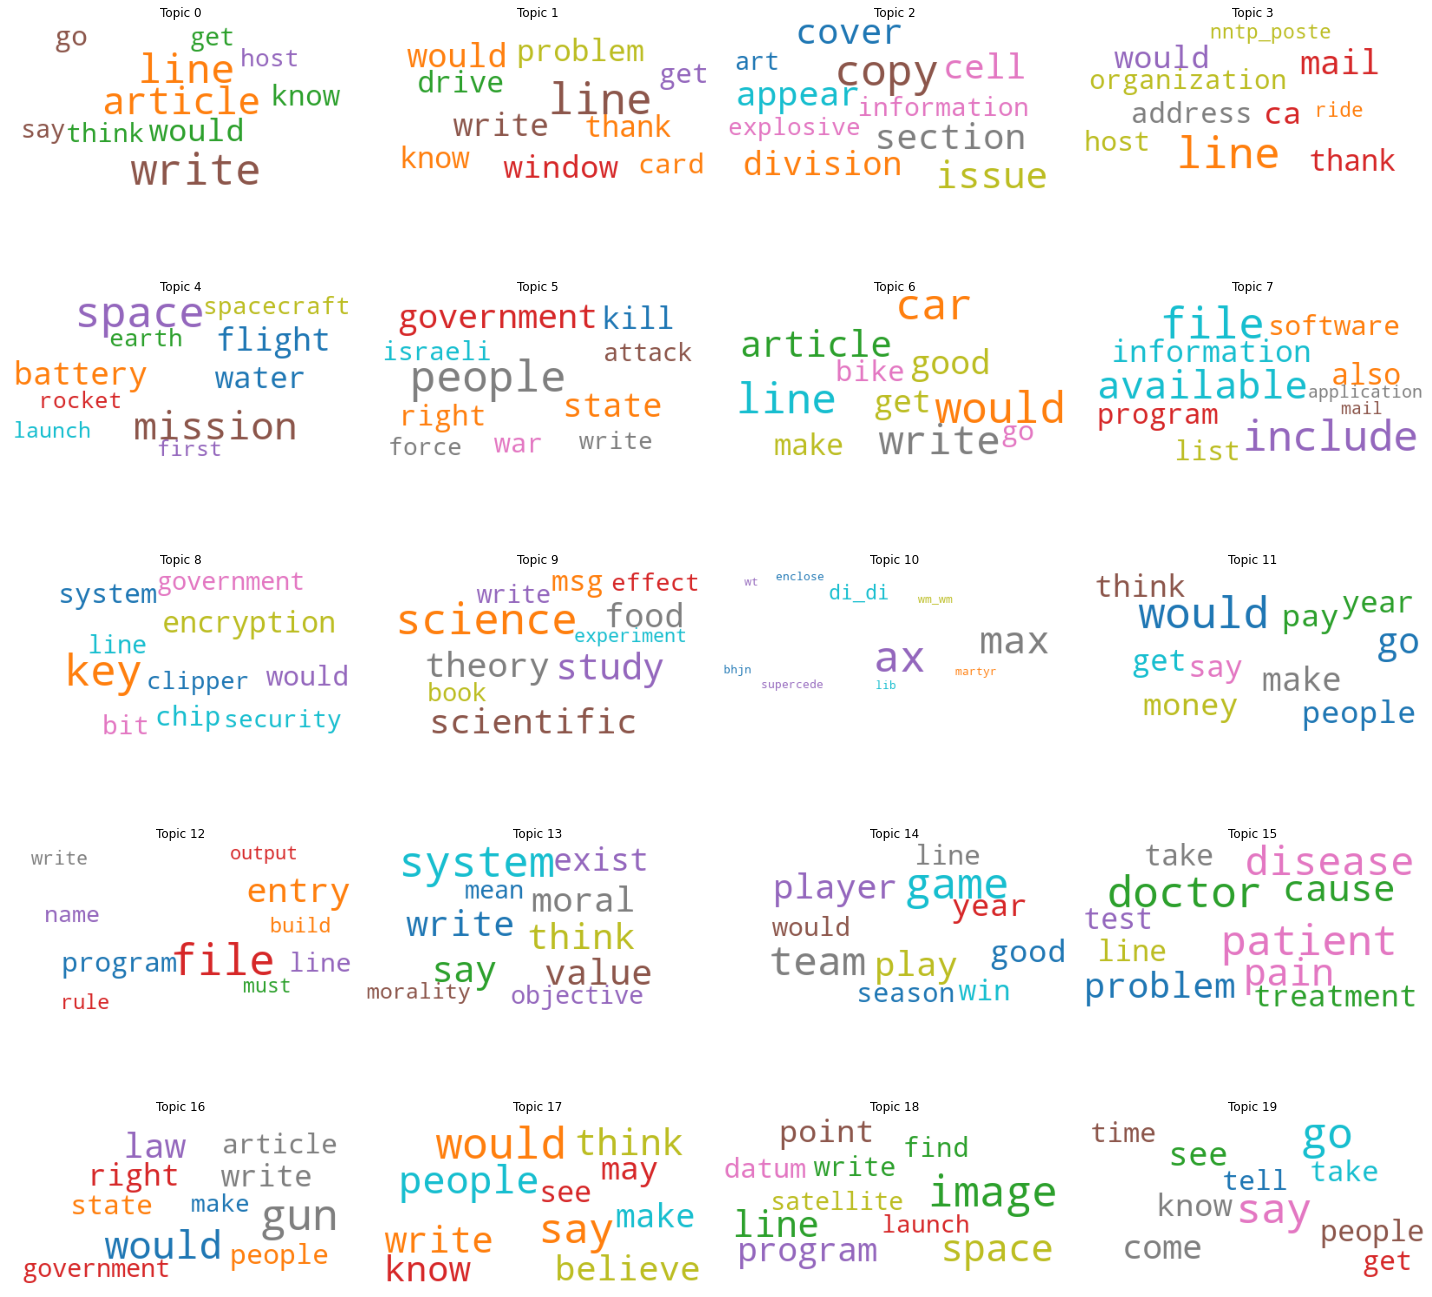

In [91]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=50)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()